<a href="https://colab.research.google.com/github/Marshmellowon/Mnist_GAN/blob/master/Infogan_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.layers import Lambda, ReLU, Input, concatenate, InputLayer, Flatten, Conv2D, Dense, BatchNormalization, Flatten, LeakyReLU, Dropout, Reshape, Conv2DTranspose
from tensorflow.keras import Sequential, optimizers, metrics

import matplotlib.pyplot as plt

import tensorflow_probability as tfp
ds = tfp.distributions

from functools import reduce

In [ ]:
# Load and prepare the MNIST dataset
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)

y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)

# Split dataset
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype("float32") / 255.0

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


In [ ]:
batch_size = 256
noise_dim = 62
lr = 1e-4

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)
train_label = tf.data.Dataset.from_tensor_slices(y_train).batch(batch_size)
test_data = tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size)
test_label = tf.data.Dataset.from_tensor_slices(y_train).batch(batch_size)

In [ ]:
class InfoGAN(keras.Model):
  def __init__(self, **kwargs):
    super(InfoGAN, self).__init__()
    self.__dict__.update(kwargs)

    self.Generator = Sequential(self.gen)
    self.Discriminator = Sequential(self.dis)
    self.Q_net = Sequential(self.Q_Net)
 
  def noise(self, batch_size):
    return np.random.uniform(-1.0, 1.0, size=[batch_size, noise_dim])

  def latent_code(self, batch_size):
    discrete_c = np.random.multinomial(1, [1/10]*10, size=batch_size) # batch, self.categorical
    continuous_c = np.random.uniform(-1, 1, [batch_size, 2])
    concat_c = np.concatenate((discrete_c, continuous_c), axis=-1) # batch, self.categorical + self.continuous
    return concat_c

  def generator(self, noise, code, Training):
    '''gneerator에서는 noise z와 code(discrete * continuous)'''
    '''출력 G(z,c)이랑 real이랑 비교'''
    x = tf.concat((noise, code), axis=-1)

    if Training is True:
      gen = self.Generator(x, training=Training)
    else:
      gen = self.Generator(x, training=Training)
    return gen
  
  def discriminator(self, x):
    '''Gen 출력을 입력으로받음'''
    dis = self.Discriminator(x, training=True)
    return dis
  
  def Q_layer(self, x):
    '''Dis의 출력에 레이어 추가해서 출력 만듬'''
    '''출력은?? Dense 12 discrete 10, continuous 2'''
    Q_val = self.Q_net(x)
    return Q_val

  def Gen_loss(self, fake_output):
    return self.CELOSS(tf.ones_like(fake_output), fake_output)

  def Dis_loss(self, real_output, fake_output):
    real_loss = self.CELOSS(tf.ones_like(real_output), real_output)
    fake_loss = self.CELOSS(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss 
    return total_loss

  def Q_loss(self, Q_output, lat_code):
    return self.q_loss(Q_output, lat_code)

  def compute_gradient(self, x, bat_size):
    noise = self.noise(bat_size)
    latent_code = self.latent_code(bat_size)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape, tf.GradientTape() as q_tape:
      generated_img = self.generator(noise, latent_code, True)

      real_output = self.discriminator(x)
      fake_output = self.discriminator(generated_img)

      Q_output = self.Q_layer(fake_output)
    
      gen_loss = self.Gen_loss(fake_output)
      dis_loss = self.Dis_loss(real_output, fake_output)
      q_loss = self.Q_loss(Q_output, latent_code)

    gen_grad = gen_tape.gradient(gen_loss, self.Generator.trainable_variables)
    dis_grad = dis_tape.gradient(dis_loss, self.Discriminator.trainable_variables)
    q_grad = q_tape.gradient(q_loss, self.Q_net.trainable_variables)

    return gen_grad, dis_grad, q_grad, gen_loss, dis_loss, q_loss

  def train(self, x, bat_size):
    gen_grad, dis_grad, q_grad, gen_loss, dis_loss, q_loss = self.compute_gradient(x, bat_size)
    self.gen_optim.apply_gradients(zip(gen_grad, self.Generator.trainable_variables))
    self.dis_optim.apply_gradients(zip(dis_grad, self.Discriminator.trainable_variables))
    self.gen_optim.apply_gradients(zip(q_grad, self.Q_net.trainable_variables))
  
    return gen_loss, dis_loss, q_loss


In [ ]:
gen_nn_Dense = [
                Dense(256, input_dim=74),
                
                Dense(1024),
                BatchNormalization(),
                ReLU(),

                Dense(7*7*128),
                BatchNormalization(),
                ReLU(),

                Reshape((7,7,128)),

                Conv2DTranspose(64, 4, (2,2), padding='same'),
                BatchNormalization(),
                ReLU(),

                Conv2DTranspose(1, 4, (2,2), padding='same', activation='sigmoid')]

'''https://github.com/eriklindernoren/Keras-GAN/blob/master/infogan/infogan.py'''
dis_nn_Dense = [
                Conv2D(64, 4, (2,2), padding='same', activation='relu', input_shape=[28,28,1]),
                
                Conv2D(128, 4, (2,2), padding='same'),
                ReLU(),
                BatchNormalization(),

                Conv2D(256, 3, (2, 2), padding='same'),
                ReLU(),
                BatchNormalization(),

                Conv2D(512, 3, (2,2), padding='same'),
                ReLU(),
                BatchNormalization(),
                
                Flatten(),
                Dense(1)
                ]
'''https://www.researchgate.net/figure/The-architectures-of-InfoGAN-and-SCGAN-InfoGAN-attempts-to-separate-the-condition-which_fig1_327949545'''
'''https://haawron.tistory.com/10 -> categorical'''
q_net = [
      Dense(128, input_shape=[1]),
      ReLU(),
      BatchNormalization(),
      Dense(12)
]

In [ ]:
gen_optim = optimizers.Adam(0.001, beta_1=0.5)
dis_optim = optimizers.Adam(0.001, beta_1=0.5)
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)
Q_loss = keras.losses.MeanSquaredError()

In [ ]:
infogan = InfoGAN(
    gen=gen_nn_Dense,
    dis=dis_nn_Dense,
    Q_Net=q_net,
    gen_optim=gen_optim,
    dis_optim=dis_optim,
    q_loss=Q_loss,
    CELOSS=cross_entropy
)

In [ ]:
infogan.Q_net.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               256       
_________________________________________________________________
re_lu_6 (ReLU)               (None, 128)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dense_5 (Dense)              (None, 12)                1548      
Total params: 2,316
Trainable params: 2,060
Non-trainable params: 256
_________________________________________________________________


In [ ]:
train_gen_loss = metrics.Mean(name='train_generator_loss')
train_dis_loss = metrics.Mean(name='train_discriminator_loss')
test_gen_loss = metrics.Mean(name='test_generator_loss')
test_dis_loss = metrics.Mean(name='test_discriminator_loss')
q_loss = metrics.Mean(name='loss_q')

In [ ]:
def show_generated_img(model, epoch, noise, latent_code):
  predict = model.generator(noise, latent_code, False)
  
  fig = plt.figure(figsize=(7, 7))

  for i in range(predict.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predict[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  plt.savefig(f'/content/drive/MyDrive/Colab/Graduation_paper/InfoGAN/infogan/gen_img{epoch}.png')        
  plt.show()

In [ ]:
def show_loss(gen, dis, qloss, epoch):

  plt.plot(epoch, gen, label='gen train')
    # plt.plot(epoch, tgen, label='gen test')
  plt.plot(epoch, dis, label='dis train')
  plt.plot(epoch, qloss, label='q')
  plt.legend()
  plt.show()

Epoch: 0, Gen[train]: 4.26154899597168, Dis[train]: 0.8096317648887634, Q[train]: 0.13089193403720856


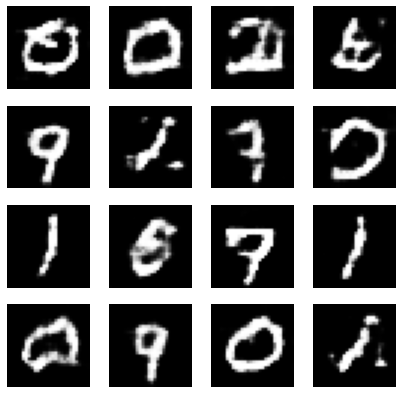

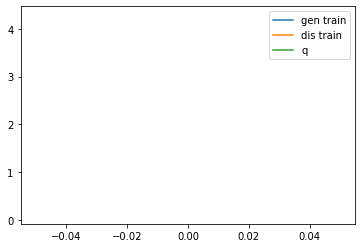

time: 67.2489697933197 
Epoch: 1, Gen[train]: 2.597527265548706, Dis[train]: 0.5881637930870056, Q[train]: 0.13348296284675598
Epoch: 2, Gen[train]: 2.720304250717163, Dis[train]: 0.5297173261642456, Q[train]: 0.13017435371875763
Epoch: 3, Gen[train]: 3.2223193645477295, Dis[train]: 0.4130973517894745, Q[train]: 0.13114506006240845
Epoch: 4, Gen[train]: 3.488842248916626, Dis[train]: 0.35494545102119446, Q[train]: 0.13093821704387665
Epoch: 5, Gen[train]: 3.757883310317993, Dis[train]: 0.331429123878479, Q[train]: 0.13797447085380554


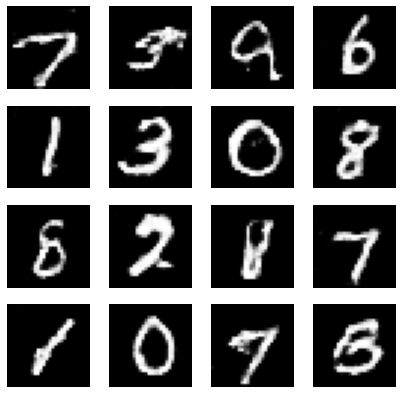

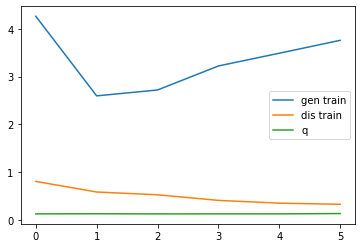

time: 239.94724321365356 
Epoch: 6, Gen[train]: 3.8060097694396973, Dis[train]: 0.343501478433609, Q[train]: 0.13228054344654083
Epoch: 7, Gen[train]: 4.29640531539917, Dis[train]: 0.1906866431236267, Q[train]: 0.15350979566574097
Epoch: 8, Gen[train]: 4.2602667808532715, Dis[train]: 0.31400367617607117, Q[train]: 0.13353343307971954
Epoch: 9, Gen[train]: 4.646833896636963, Dis[train]: 0.17193222045898438, Q[train]: 0.1324777901172638
Epoch: 10, Gen[train]: 4.776840686798096, Dis[train]: 0.25332990288734436, Q[train]: 0.1327105462551117


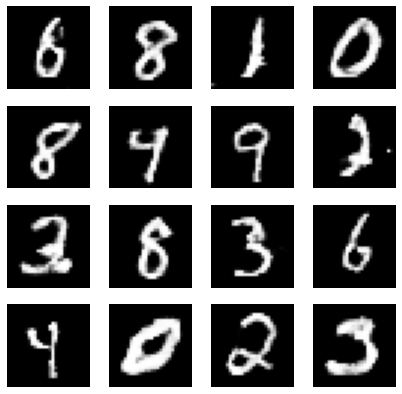

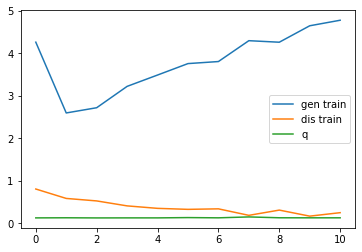

time: 412.4746789932251 
Epoch: 11, Gen[train]: 5.132040500640869, Dis[train]: 0.12221606820821762, Q[train]: 0.13584133982658386
Epoch: 12, Gen[train]: 5.436461925506592, Dis[train]: 0.15275788307189941, Q[train]: 0.12938721477985382
Epoch: 13, Gen[train]: 5.350376605987549, Dis[train]: 0.19246496260166168, Q[train]: 0.12825904786586761
Epoch: 14, Gen[train]: 5.840612411499023, Dis[train]: 0.1360550820827484, Q[train]: 0.1307086944580078
Epoch: 15, Gen[train]: 5.5964155197143555, Dis[train]: 0.1243395283818245, Q[train]: 0.13291414082050323


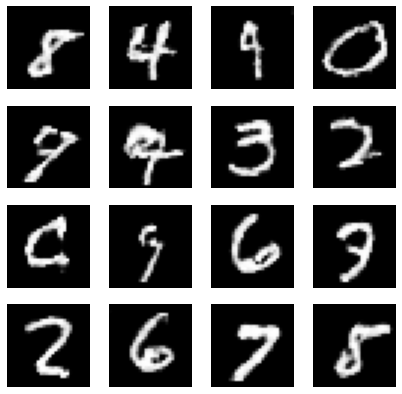

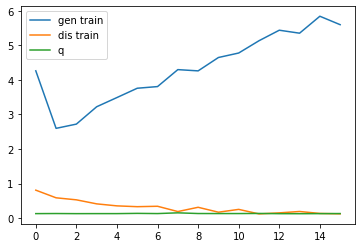

time: 584.8106095790863 
Epoch: 16, Gen[train]: 5.72468900680542, Dis[train]: 0.12687191367149353, Q[train]: 0.12803572416305542
Epoch: 17, Gen[train]: 5.908123970031738, Dis[train]: 0.15208996832370758, Q[train]: 0.133029043674469
Epoch: 18, Gen[train]: 5.887146472930908, Dis[train]: 0.06775509566068649, Q[train]: 0.132610023021698
Epoch: 19, Gen[train]: 5.755447864532471, Dis[train]: 0.2258811593055725, Q[train]: 0.1305040717124939
Epoch: 20, Gen[train]: 5.770485877990723, Dis[train]: 0.13169248402118683, Q[train]: 0.12879449129104614


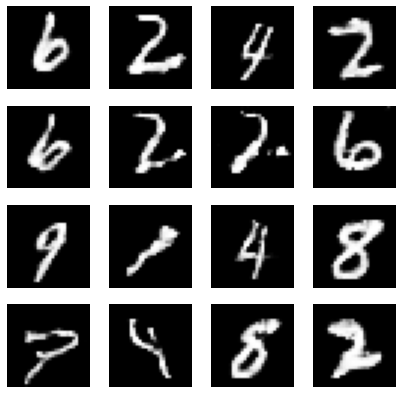

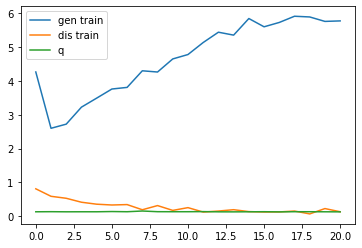

time: 756.2461996078491 
Epoch: 21, Gen[train]: 5.934945583343506, Dis[train]: 0.129268079996109, Q[train]: 0.1288273185491562
Epoch: 22, Gen[train]: 6.370477199554443, Dis[train]: 0.08235005289316177, Q[train]: 0.1314423531293869
Epoch: 23, Gen[train]: 6.416804790496826, Dis[train]: 0.049805160611867905, Q[train]: 0.12902820110321045
Epoch: 24, Gen[train]: 6.261690616607666, Dis[train]: 0.16766142845153809, Q[train]: 0.12957850098609924
Epoch: 25, Gen[train]: 6.086799621582031, Dis[train]: 0.11790980398654938, Q[train]: 0.131360724568367


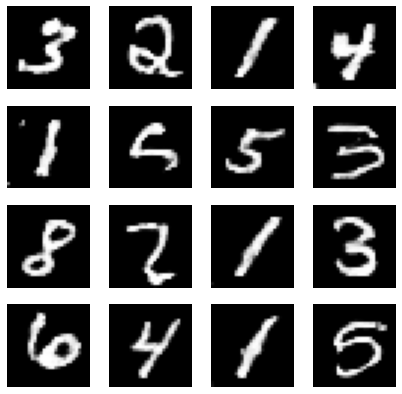

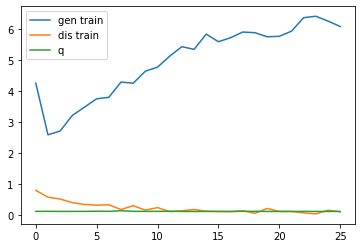

time: 929.2053868770599 
Epoch: 26, Gen[train]: 6.420964241027832, Dis[train]: 0.024365589022636414, Q[train]: 0.12712976336479187
Epoch: 27, Gen[train]: 6.114476680755615, Dis[train]: 0.2196030616760254, Q[train]: 0.1311311274766922
Epoch: 28, Gen[train]: 6.2579874992370605, Dis[train]: 0.07672052830457687, Q[train]: 0.14583508670330048
Epoch: 29, Gen[train]: 6.197168827056885, Dis[train]: 0.13625608384609222, Q[train]: 0.12965968251228333
Epoch: 30, Gen[train]: 6.407698154449463, Dis[train]: 0.1452823132276535, Q[train]: 0.13245642185211182


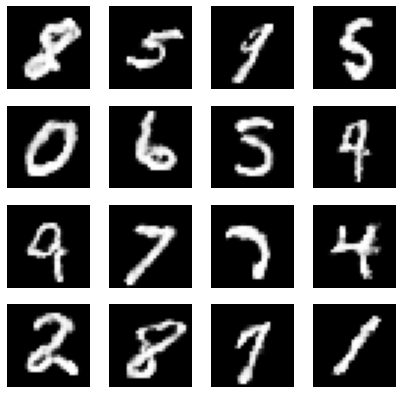

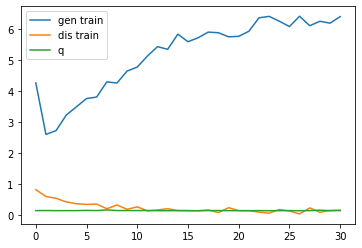

time: 1102.3781852722168 
Epoch: 31, Gen[train]: 6.203932762145996, Dis[train]: 0.04786767065525055, Q[train]: 0.13083580136299133


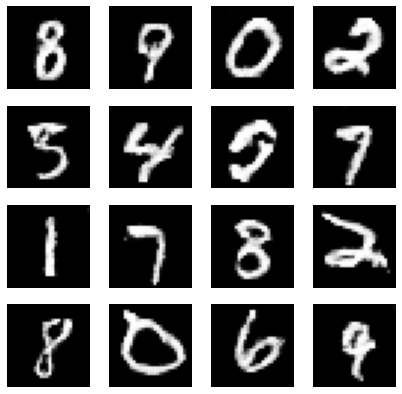

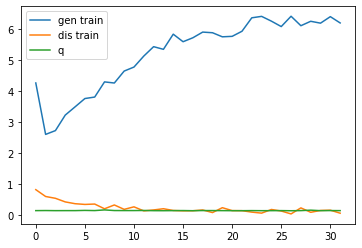

time: 1137.97469830513 
Epoch: 32, Gen[train]: 6.550662994384766, Dis[train]: 0.09422572702169418, Q[train]: 0.12913024425506592


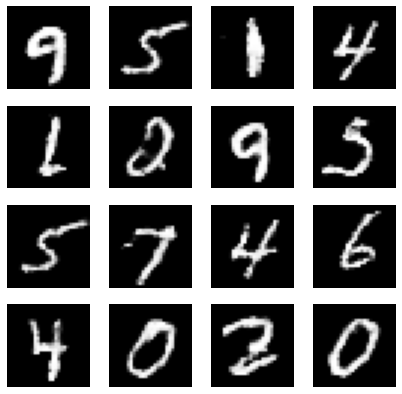

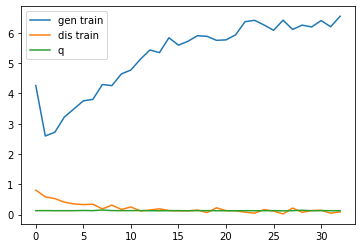

time: 1173.0829865932465 
Epoch: 33, Gen[train]: 6.401000499725342, Dis[train]: 0.0851091518998146, Q[train]: 0.1291881799697876


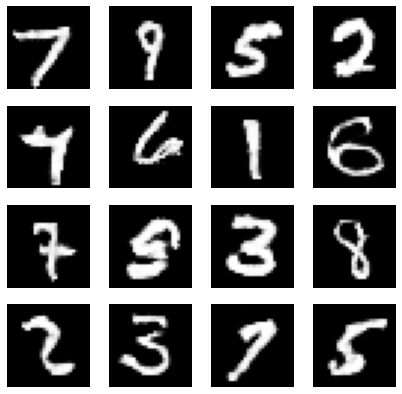

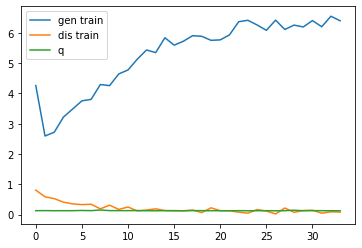

time: 1208.920450925827 
Epoch: 34, Gen[train]: 6.985456466674805, Dis[train]: 0.015382450073957443, Q[train]: 0.129491925239563


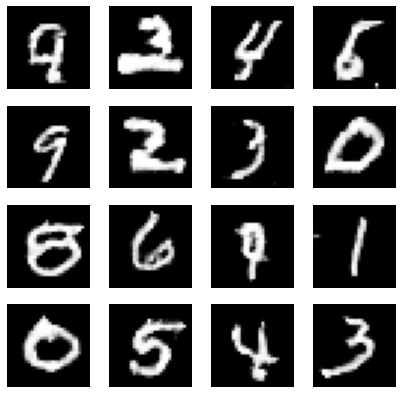

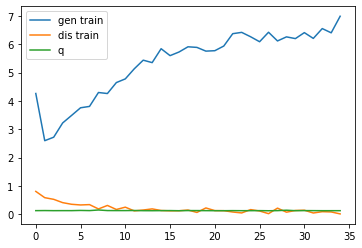

time: 1244.539534330368 
Epoch: 35, Gen[train]: 7.472479820251465, Dis[train]: 0.011929832398891449, Q[train]: 0.13258738815784454


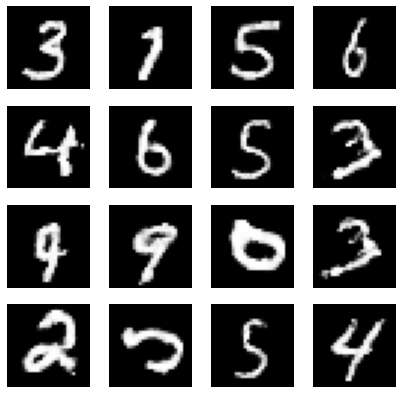

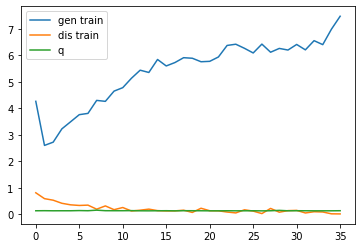

time: 1279.8806676864624 
Epoch: 36, Gen[train]: 7.843438625335693, Dis[train]: 0.008074014447629452, Q[train]: 0.128598153591156


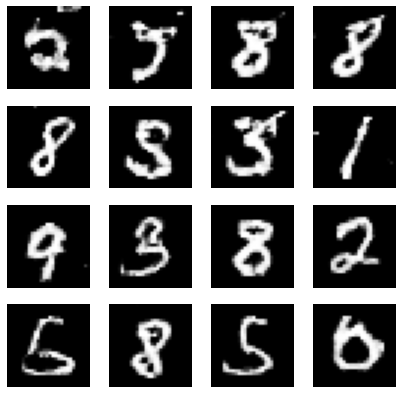

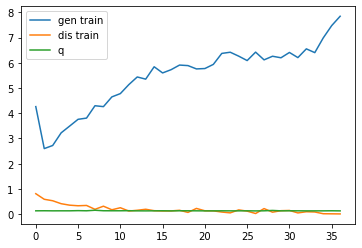

time: 1316.4924101829529 
Epoch: 37, Gen[train]: 8.19731616973877, Dis[train]: 0.15237915515899658, Q[train]: 0.13263025879859924


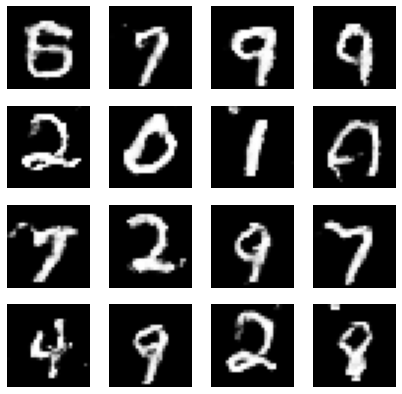

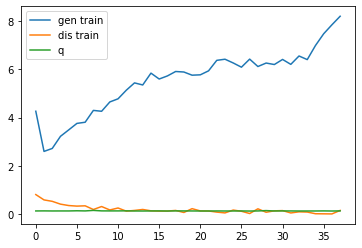

time: 1351.9913818836212 
Epoch: 38, Gen[train]: 7.061846733093262, Dis[train]: 0.13143745064735413, Q[train]: 0.1243622750043869


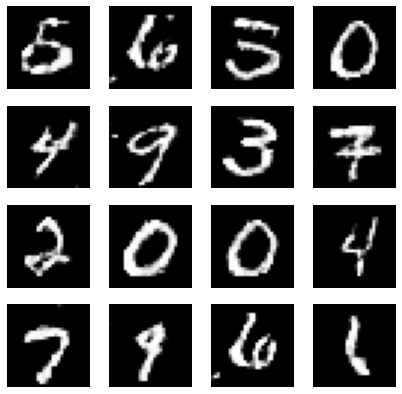

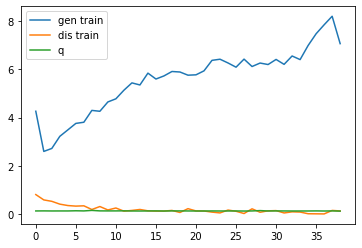

time: 1387.455185174942 
Epoch: 39, Gen[train]: 7.545075416564941, Dis[train]: 0.10279994457960129, Q[train]: 0.12884804606437683


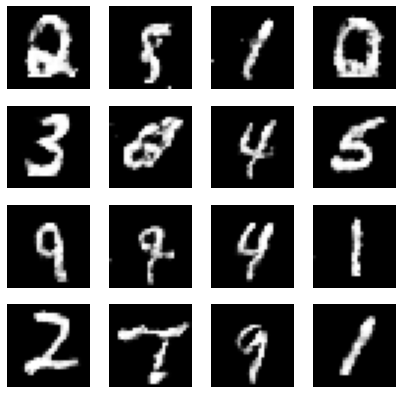

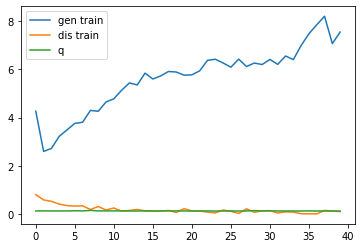

time: 1423.328246831894 
Epoch: 40, Gen[train]: 6.449776649475098, Dis[train]: 0.028749333694577217, Q[train]: 0.1316993683576584


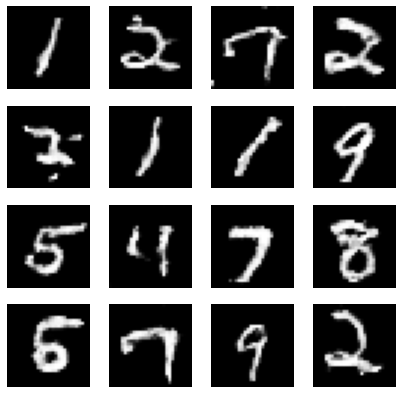

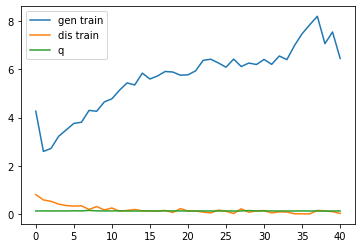

time: 1458.6458184719086 
Epoch: 41, Gen[train]: 7.456077575683594, Dis[train]: 0.02470145747065544, Q[train]: 0.13250845670700073


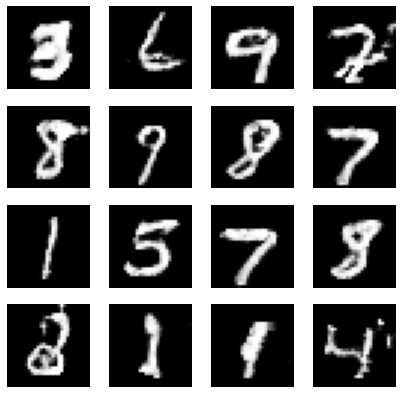

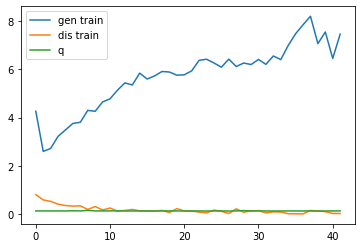

time: 1494.325930595398 
Epoch: 42, Gen[train]: 7.509018421173096, Dis[train]: 0.009466027840971947, Q[train]: 0.1297997534275055


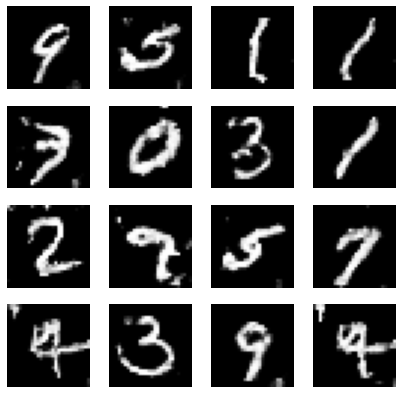

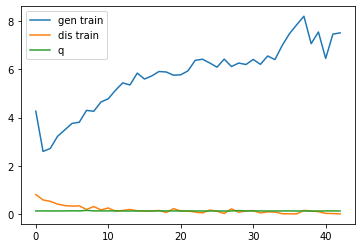

time: 1530.2832329273224 
Epoch: 43, Gen[train]: 7.809691905975342, Dis[train]: 0.006672399118542671, Q[train]: 0.13468071818351746


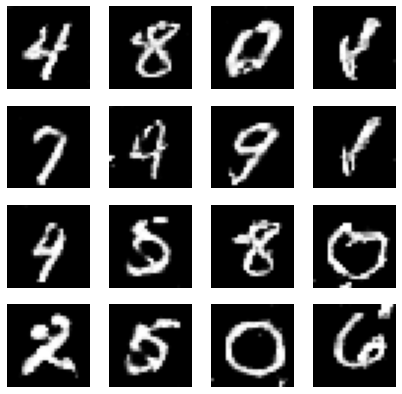

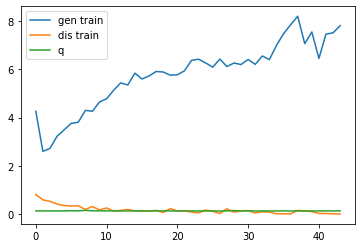

time: 1566.2555124759674 
Epoch: 44, Gen[train]: 8.20175552368164, Dis[train]: 0.13748854398727417, Q[train]: 0.1291135996580124


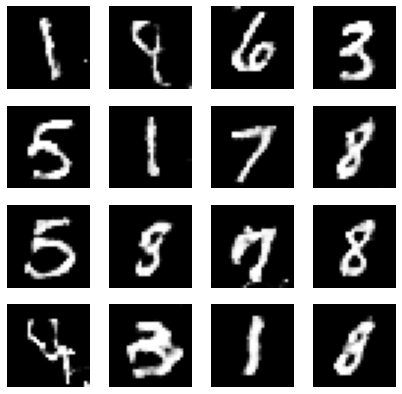

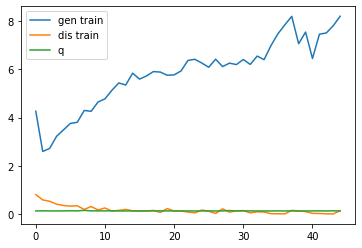

time: 1602.0332624912262 
Epoch: 45, Gen[train]: 7.776017665863037, Dis[train]: 0.022966699674725533, Q[train]: 0.12857286632061005


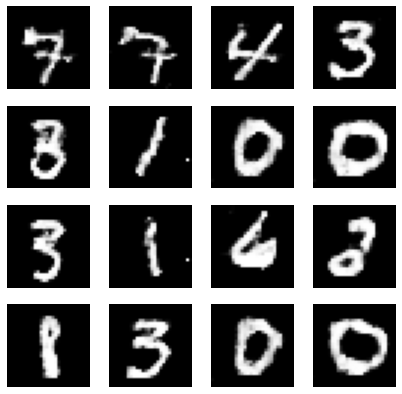

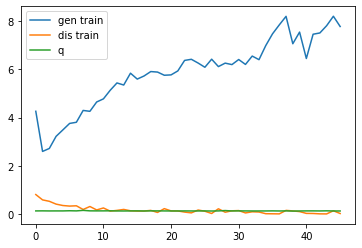

time: 1637.6918413639069 
Epoch: 46, Gen[train]: 8.230877876281738, Dis[train]: 0.15566694736480713, Q[train]: 0.12908583879470825


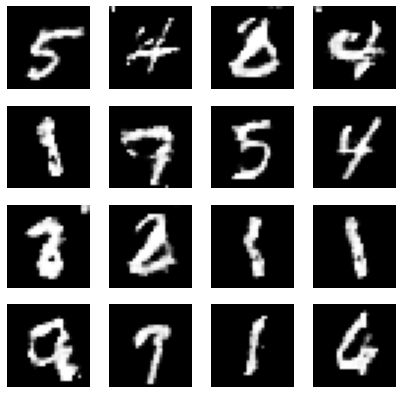

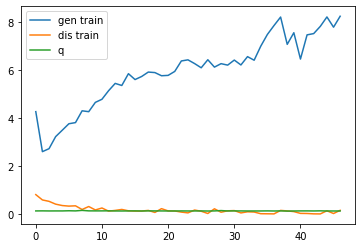

time: 1673.5001068115234 
Epoch: 47, Gen[train]: 6.393860816955566, Dis[train]: 0.11222954094409943, Q[train]: 0.12714442610740662


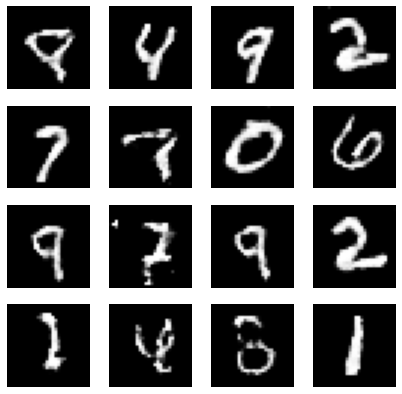

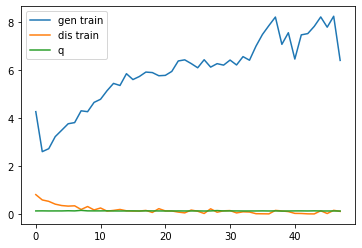

time: 1709.2348437309265 
Epoch: 48, Gen[train]: 6.917442321777344, Dis[train]: 0.07567029446363449, Q[train]: 0.13578878343105316


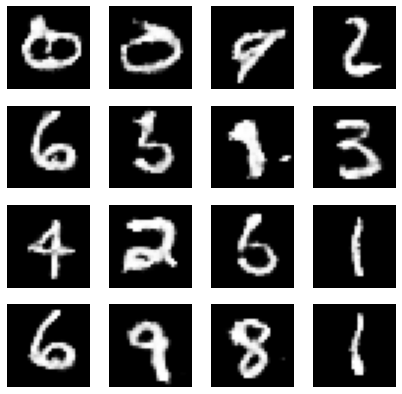

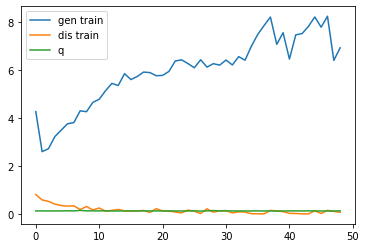

time: 1744.9586780071259 
Epoch: 49, Gen[train]: 7.285908222198486, Dis[train]: 0.03049720823764801, Q[train]: 0.12952782213687897


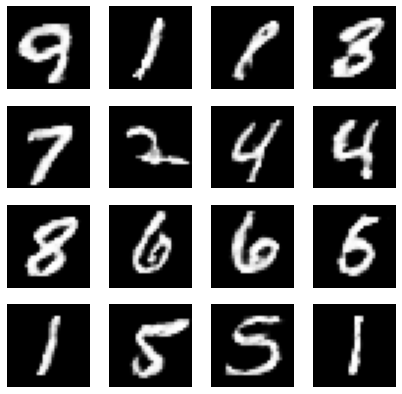

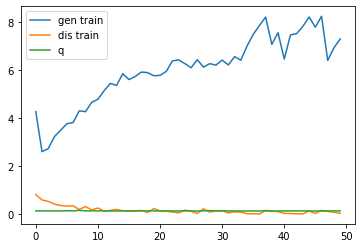

time: 1780.6893582344055 


In [ ]:
import time
display_step = 5
num_examples_to_generate = 16

train_range = 50
gen_loss_arr = []
dis_loss_arr = []
q_loss_arr = []
EPOCH=[]

strat_time = time.time()
for epoch in range(train_range):
  i = 0
  for x_batch in train_data:
    gen_loss, dis_loss, q_loss_ = infogan.train(x_batch, batch_size)
    train_gen_loss(gen_loss)
    train_dis_loss(dis_loss)
  
  for x_batch in test_data:
    a, b, c, loss_gen_t, loss_dis_t, q_loss = infogan.compute_gradient(x_batch, batch_size)
    test_gen_loss(loss_gen_t)
    test_dis_loss(loss_dis_t)
    
  

  gen_loss_arr.append(train_gen_loss.result())
  dis_loss_arr.append(train_dis_loss.result())
  q_loss_arr.append(q_loss)
  EPOCH.append(epoch)

  print(f'Epoch: {epoch}, Gen[train]: {train_gen_loss.result()}, Dis[train]: {train_dis_loss.result()}, Q[train]: {q_loss}')

  if epoch % display_step == 0 or epoch >= 30:
    noise = infogan.noise(num_examples_to_generate)
    latent_code = infogan.latent_code(num_examples_to_generate)

    show_generated_img(infogan, epoch + 1, noise, latent_code)
    show_loss(gen_loss_arr, dis_loss_arr, q_loss_arr, EPOCH)
    print(f'time: {time.time() - strat_time} ')

  train_gen_loss.reset_states()
  train_dis_loss.reset_states()
  test_gen_loss.reset_states()
  test_dis_loss.reset_states()